In [5]:
import os
import sys
sys.path.insert(0, os.path.abspath('../../cvxportfolio'))

In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxportfolio as cp

plotdir = 'plots/'
datadir='data/'

sigmas=pd.read_csv(datadir+'sigmas.csv.gz',index_col=0,parse_dates=[0]).iloc[:,:-1]
returns=pd.read_csv(datadir+'returns.csv.gz',index_col=0,parse_dates=[0])
volumes=pd.read_csv(datadir+'volumes.csv.gz',index_col=0,parse_dates=[0]).iloc[:,:-1]


#, 'NKE', 'IBM', 'BAC', 'C'
subset_tickers  = list(volumes.ix[:, (volumes > 0).all()].columns)[:30] + ["USDOLLAR"]
sigmas = sigmas.ix[:, sigmas.columns.isin(subset_tickers)]
returns = returns.ix[:, returns.columns.isin(subset_tickers)]
volumes = volumes.ix[:, volumes.columns.isin(subset_tickers)]


w_b = pd.Series(index=returns.columns, data=1)
w_b.USDOLLAR = 0.
w_b/=sum(w_b)

start_t="2014-01-01"
end_t="2016-12-31"

simulated_tcost = cp.TcostModel(half_spread=0.0005/2., nonlin_coeff=1., sigma=sigmas, volume=volumes)
simulated_hcost = cp.HcostModel(borrow_costs=0.0001)
simulator = cp.MarketSimulator(returns, costs=[simulated_tcost, simulated_hcost],
                               market_volumes=volumes, cash_key='USDOLLAR')

return_estimate=pd.read_csv(datadir+'return_estimate.csv.gz',index_col=0,parse_dates=[0]).dropna()
volume_estimate=pd.read_csv(datadir+'volume_estimate.csv.gz',index_col=0,parse_dates=[0]).dropna()
sigma_estimate=pd.read_csv(datadir+'sigma_estimate.csv.gz',index_col=0,parse_dates=[0]).dropna()

#, 'NKE', 'IBM', 'BAC', 'C'
return_estimate = return_estimate.ix[:, return_estimate.columns.isin(subset_tickers)]
volume_estimate = volume_estimate.ix[:, volume_estimate.columns.isin(subset_tickers)]
sigma_estimate = sigma_estimate.ix[:, sigma_estimate.columns.isin(subset_tickers)]


optimization_tcost = cp.TcostModel(half_spread=0.0005/2., nonlin_coeff=1., 
                                sigma=sigma_estimate, volume=volume_estimate)
optimization_hcost=cp.HcostModel(borrow_costs=0.0001)

risk_data = pd.HDFStore(datadir+'risk_model.h5')
risk_model = cp.FactorModelSigma(risk_data.exposures, risk_data.factor_sigma, risk_data.idyos)


Sigma_hat = returns.rolling(window=250, min_periods=250).cov().unstack().shift(1).stack().dropna()
risk_model = cp.FullSigma(Sigma_hat)

results={}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for 

# SPO coarse search

In [7]:
policies={}
gamma_risks_coarse=[.1,.3,1,3,10,30,100,300,1000]
gamma_tcosts_coarse=[1,2,5,10,20]
for gamma_risk in gamma_risks_coarse:
    for gamma_tcost in gamma_tcosts_coarse : 
        policies[(gamma_risk, gamma_tcost)] = \
      cp.SinglePeriodOpt(return_estimate, [gamma_risk*risk_model,gamma_tcost*optimization_tcost,optimization_hcost], 
                                [cp.LeverageLimit(3)])

import warnings
warnings.filterwarnings('ignore')
results.update(dict(zip(policies.keys(), simulator.run_multiple_backtest(1E8*w_b, start_time=start_t,end_time=end_t,
                                              policies=policies.values(), parallel=True))))

In [8]:
result_df_coarse=pd.DataFrame()
for k in results:
    if k[0] in gamma_risks_coarse and k[1] in gamma_tcosts_coarse:
        result_df_coarse.loc[k[0], k[1]] = results[k]
        
result_df = result_df_coarse.loc[sorted(result_df_coarse.index), sorted(result_df_coarse.columns)]

[35.130031990920088, 34.786101590802851, 33.785476285139779, 31.372473901228304, 25.830483837798791, 17.548818842581198, 10.273842727767269, 5.2530124812894305, 1.8081974803147542] [-50.427747866742905, -51.02157211548391, -52.79941111423579, -54.34648670169402, -51.912382130735494, -48.339654161585635, -40.34215160012381, -21.176340637132032, -5.687913426059869]
[22.223233004954121, 21.884085244940206, 20.91886203241047, 19.141386886340729, 15.579413665443523, 11.294559213914225, 7.1553873315974412, 3.4589426657633622, 1.3561794937961824] [5.391202443274571, 5.54209660709387, 6.361345966574562, 7.6244531118951056, 7.183912079307487, -0.22474546791677655, -4.9684507020656214, -2.886859250851341, -0.9534442512928434]
[22.699175261884275, 21.429348927515285, 17.521445977371013, 12.619110372117234, 9.2689505385929678, 6.3072890925705858, 3.2222901129521424, 1.6714033955919267, 0.76902117648872104] [22.81944554204287, 22.66251515562261, 19.874449502604122, 14.008572407942118, 7.95178319112

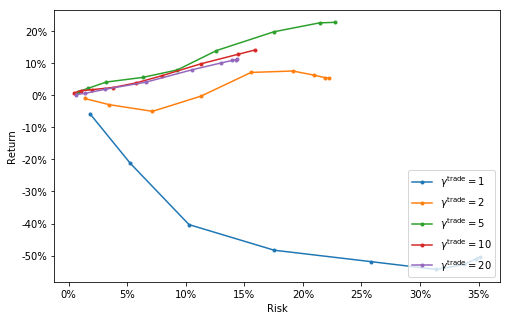

In [9]:
plt.figure(figsize=(8,5))
for gamma_tcost in result_df.columns:
    x=[el.excess_returns.std()*100*np.sqrt(250) for el in result_df[gamma_tcost]]
    y=[el.excess_returns.mean()*100*250 for el in result_df[gamma_tcost]]
    print(x,y)
    plt.plot(np.array(x),np.array(y), '.-', label='$\gamma^\mathrm{trade} = %g$'%gamma_tcost)
plt.legend(loc='lower right')
plt.xlabel('Risk')
plt.ylabel('Return')
#plt.xlim([0,20])
#plt.ylim([0,30])


import matplotlib.ticker as mtick
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))

#plt.savefig(plotdir+'spo_riskrewardfrontier.png')

# SPO fine Search 

In [10]:
policies={}
gamma_risks_fine=gamma_risks_coarse
gamma_tcosts_fine=[4,5,6,7,8]
for gamma_risk in gamma_risks_fine:
    for gamma_tcost in gamma_tcosts_fine : 
        policies[(gamma_risk, gamma_tcost)] = \
      cp.SinglePeriodOpt(return_estimate, [gamma_risk*risk_model,gamma_tcost*optimization_tcost,optimization_hcost], 
                                [cp.LeverageLimit(3)])

import warnings
warnings.filterwarnings('ignore')
results.update(dict(zip(policies.keys(), simulator.run_multiple_backtest(1E8*w_b, start_time=start_t,end_time=end_t,
                                              policies=policies.values(), parallel=True))))

In [11]:
result_df_fine=pd.DataFrame()
for k in results:
    if k[0] in gamma_risks_fine and k[1] in list(gamma_tcosts_fine):
        result_df_fine.loc[k[0], k[1]] = results[k]
        
result_df_fine=result_df_fine.loc[sorted(result_df_fine.index),sorted(result_df_fine.columns)]

[20.792005376182043, 19.918456318888069, 17.873150529172893, 14.452051933483025, 10.427360789171017, 7.2495581971696472, 3.9366907748256161, 2.0377270816150794, 0.90192864083080448] [26.42537431931029, 26.107286035310906, 24.54817294095197, 19.008073903409482, 10.945828951332158, 7.695944429490099, 4.258105075875237, 2.167692899345727, 0.9554320881116317]
[22.699175261884275, 21.429348927515285, 17.521445977371013, 12.619110372117234, 9.2689505385929678, 6.3072890925705858, 3.2222901129521424, 1.6714033955919267, 0.76902117648872104] [22.81944554204287, 22.66251515562261, 19.874449502604122, 14.008572407942118, 7.951783191128164, 5.615589573851685, 4.188193213324863, 2.2501604693584545, 1.074476307366325]
[24.372763988352489, 22.703928515298362, 16.979819224672347, 11.011614152755575, 8.2429158772632114, 5.4221411738539711, 2.7683159600731795, 1.428005682581633, 0.66765889903209441] [20.971167382940084, 20.459371526289086, 17.02741097025299, 10.890581396351315, 6.588658083111881, 4.562

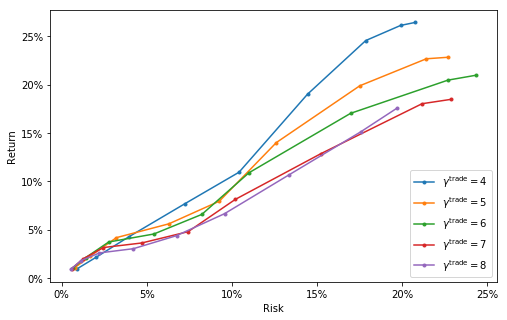

In [12]:
plt.figure(figsize=(8,5))
for gamma_tcost in result_df_fine.columns[:]:
    x=[el.excess_returns.std()*100*np.sqrt(250) for el in result_df_fine[gamma_tcost]]
    y=[el.excess_returns.mean()*100*250 for el in result_df_fine[gamma_tcost]]
    print(x,y)
    plt.plot(np.array(x),np.array(y), '.-', label='$\gamma^\mathrm{trade} = %g$'%gamma_tcost)
plt.legend(loc='lower right')
plt.xlabel('Risk')
plt.ylabel('Return')


import matplotlib.ticker as mtick
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))

#plt.savefig(plotdir+'spo_riskrewardfrontier_fine.png')

# SPO Pareto search 

In [13]:
results_pareto={}

In [14]:
policies={}
#gamma_risks_pareto=[int(round(el)) if el>1 else el for el in np.logspace(-1,3,17)]
gamma_risks_pareto=[0.1, 0.17782, 0.31624, 0.562, 1.0, 2, 3, 6, 10, 18, 32, 56, 100, 178, 316, 562, 1000]
gamma_tcosts_pareto=[5.5,6,6.5,7,7.5,8]
gamma_holdings=[.1,1.,10.,100.,1000.]
for gamma_risk in gamma_risks_pareto:
    for gamma_tcost in gamma_tcosts_pareto : 
        for gamma_holding in gamma_holdings:
            policies[(gamma_risk, gamma_tcost, gamma_holding)] = \
          cp.SinglePeriodOpt(return_estimate, [gamma_risk*risk_model,gamma_tcost*optimization_tcost,\
                                       gamma_holding*optimization_hcost], 
                                [cp.LeverageLimit(3)])

import warnings
warnings.filterwarnings('ignore')
results_pareto.update(dict(zip(policies.keys(), simulator.run_multiple_backtest(1E8*w_b, start_time=start_t,end_time=end_t,
                                              policies=policies.values(), parallel=True))))

In [15]:
table=pd.DataFrame()
table[r'$\gamma^\mathrm{risk}$']=[el[0] for el in results_pareto.keys()]
table[r'$\gamma^\mathrm{trade}$']=[el[1] for el in results_pareto.keys()]
table[r'$\gamma^\mathrm{hold}$']=['%g'%el[2] for el in results_pareto.keys()]
table['Return']=[(results_pareto[k].excess_returns.mean()*100*250) for k in results_pareto.keys()]
table['Risk']=[(results_pareto[k].excess_returns.std()*100*np.sqrt(250)) for k in results_pareto.keys()]
table = table.sort_values('Risk', ascending=False).reset_index()
del table['index']
is_pareto = lambda i: table.loc[i,'Return']>=max(table.ix[i:].Return)
table['is_pareto'] = [is_pareto(i) for i in range(len(table))]
table.to_csv(datadir + 'spo_pareto_results_big_old.csv', float_format='%g')

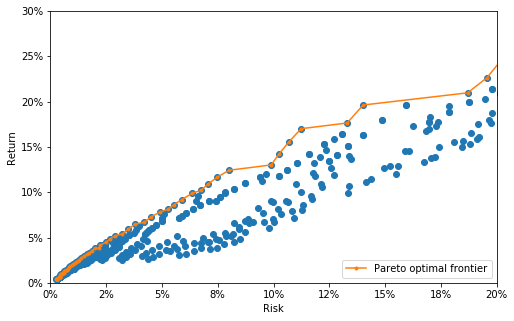

In [16]:
plt.figure(figsize=(8,5))
plt.scatter(table.Risk.values,table.Return.values)
plt.plot(table[table.is_pareto].Risk,table[table.is_pareto].Return, 'C1.-', label='Pareto optimal frontier')
plt.legend( loc='lower right')
plt.xlabel('Risk')
plt.ylabel('Return')
plt.xlim([0,20])
plt.ylim([0,30])

import matplotlib.ticker as mtick
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))

#plt.savefig(plotdir+'spo_pareto.png')

In [17]:
xlim=20
ylim=30
table=table[table.is_pareto]
table=table[table.Risk <= xlim]
table=table[table.Return <= ylim]
del table['is_pareto']
table.Risk=table.Risk.apply(lambda x: '%.2f%%'%x)
table.Return=table.Return.apply(lambda x: '%.2f%%'%x)
print(table.iloc[::-1].to_latex(float_format='%.2f', escape=False, index=False).replace('%',r'\%'))
table

\begin{tabular}{rrlll}
\toprule
 $\gamma^\mathrm{risk}$ &  $\gamma^\mathrm{trade}$ & $\gamma^\mathrm{hold}$ &  Return &    Risk \\
\midrule
                 1000.0 &                      8.0 &                   1000 &   0.37\% &   0.28\% \\
                 1000.0 &                      7.5 &                   1000 &   0.37\% &   0.28\% \\
                 1000.0 &                      7.5 &                    100 &   0.37\% &   0.28\% \\
                 1000.0 &                      7.0 &                   1000 &   0.38\% &   0.29\% \\
                 1000.0 &                      7.0 &                    100 &   0.38\% &   0.29\% \\
                 1000.0 &                      6.5 &                   1000 &   0.39\% &   0.29\% \\
                 1000.0 &                      6.5 &                    100 &   0.40\% &   0.30\% \\
                 1000.0 &                      6.0 &                   1000 &   0.40\% &   0.30\% \\
                 1000.0 &                      6.0 &

,$\gamma^\mathrm{risk}$,$\gamma^\mathrm{trade}$,$\gamma^\mathrm{hold}$,Return,Risk
112,1.0,6.0,10,22.64%,19.56%
121,1.0,6.5,10,20.97%,18.70%
154,2.0,5.5,10,19.62%,14.01%
161,2.0,6.0,10,17.64%,13.30%
186,3.0,5.5,10,17.01%,11.24%
193,3.0,6.0,10,15.53%,10.68%
201,3.0,6.5,10,14.19%,10.24%
206,3.0,7.0,10,13.01%,9.89%
232,6.0,5.5,10,12.42%,8.00%
242,6.0,6.0,10,11.65%,7.47%


In [18]:
table

,$\gamma^\mathrm{risk}$,$\gamma^\mathrm{trade}$,$\gamma^\mathrm{hold}$,Return,Risk
112,1.0,6.0,10,22.64%,19.56%
121,1.0,6.5,10,20.97%,18.70%
154,2.0,5.5,10,19.62%,14.01%
161,2.0,6.0,10,17.64%,13.30%
186,3.0,5.5,10,17.01%,11.24%
193,3.0,6.0,10,15.53%,10.68%
201,3.0,6.5,10,14.19%,10.24%
206,3.0,7.0,10,13.01%,9.89%
232,6.0,5.5,10,12.42%,8.00%
242,6.0,6.0,10,11.65%,7.47%
